# Data exploration

### Create dataset : downloading images from the the iNaturalist API

In [ ]:
# Create dataset
from jellyfish_classif.data_ingestion import download_all_species

download_all_species()

: 

### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import random

%matplotlib inline

In [3]:
# Path to dataset
images_root = Path("data/images")

# List all images and their species
records = []
for img_path in images_root.rglob("*.jpg"):
    species_name = img_path.parent.name.replace("_", " ")
    records.append({
        "image_path": str(img_path),
        "species_name": species_name
    })

df = pd.DataFrame(records)
print(df.head())

                                   image_path    species_name
0  data/images/Aurelia_aurita/175805603_0.jpg  Aurelia aurita
1  data/images/Aurelia_aurita/188767148_0.jpg  Aurelia aurita
2  data/images/Aurelia_aurita/188767148_1.jpg  Aurelia aurita
3   data/images/Aurelia_aurita/67196674_0.jpg  Aurelia aurita
4   data/images/Aurelia_aurita/67196672_0.jpg  Aurelia aurita


### Check dataset


In [4]:
nb_total = len(df)
nb_images_uniques = df['image_path'].nunique()

print(f"Total images : {nb_total}")
print(f"\nNb of species : {df['species_name'].nunique()}")



Total images : 2680

Nb of species : 5


### Images exemples

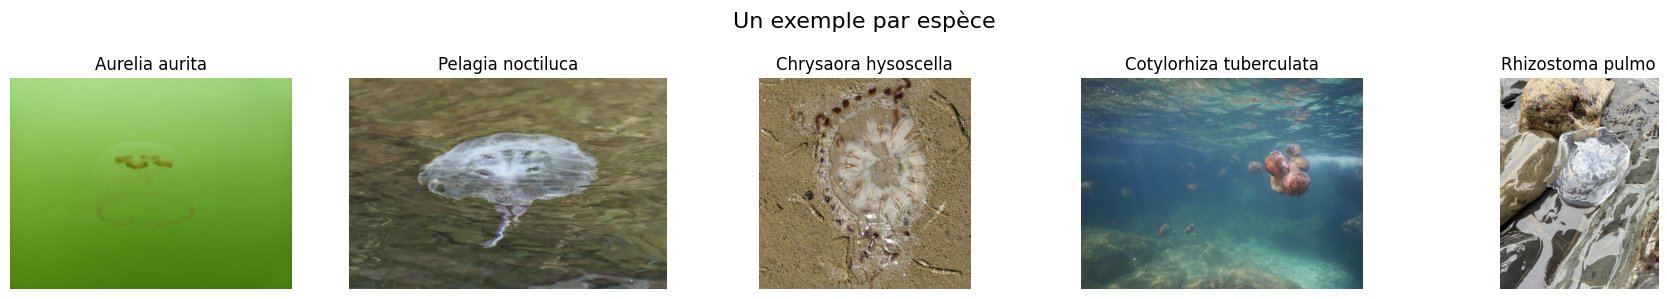

In [5]:
def show_sample_images_per_species(images_root: str = "data/images"):
    images_root = Path(images_root)
    species_dirs = [d for d in images_root.iterdir() if d.is_dir()]

    plt.figure(figsize=(18, 3))

    for i, species_dir in enumerate(species_dirs):
        image_files = list(species_dir.glob("*.jpg"))
        if not image_files:
            continue

        # Choose a random image
        img_path = random.choice(image_files)

        # Read and convert to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(species_dirs), i + 1)
        plt.imshow(img)
        plt.title(species_dir.name.replace("_", " "), fontsize=12)
        plt.axis("off")

    plt.suptitle("Un exemple par espèce", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images_per_species(images_root="data/images")

### Dataset distribution

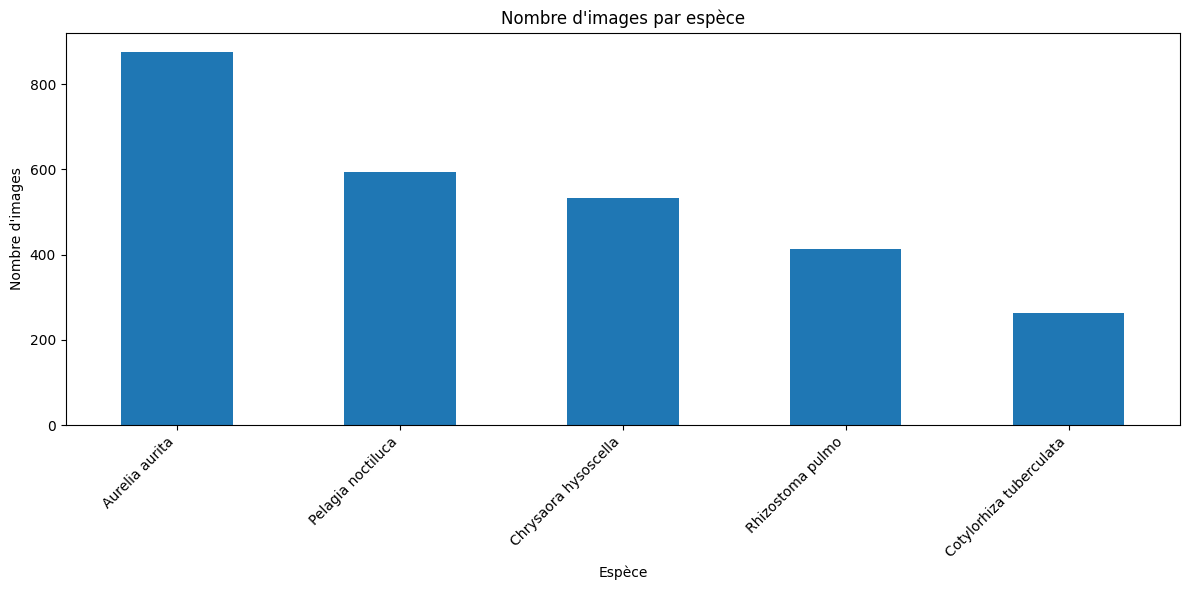

In [6]:
species_counts = df['species_name'].value_counts()

plt.figure(figsize=(12, 6))
species_counts.plot(kind='bar')
plt.title("Nombre d'images par espèce")
plt.xlabel("Espèce")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
